# bikeの特徴量の解釈
https://christophm.github.io/interpretable-ml-book/limo.html

## データの意味

- cnt:casualとregisteredのユーザーの数。回帰のターゲット
- season:spring, summer, fall or winter.
- holiday
- year: 2011 or 2012.
- dateday:2011/01/01からの日数。この特料量は時間経過によるトレンドを導くのに使用する。
- working day or weekend.
- 天気:
    - 1 clear, few clouds, partly cloudy, cloudy
    - 2 mist + clouds, mist + broken clouds, mist + few clouds, mist
    - 3 light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
    - 4 heavy rain + ice pallets + thunderstorm + mist, snow + mist
- temp：Temperature in degrees Celsius.41で割り、正規化されている。
- atemp：体感温度。50で割り、正規化されている。
- hum:湿度(0 to 100). 100で割り正規化されている。
- Wind speed: km/hour.　67で割り、正規化されている。

In [1]:
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing
import pandas as pd
import seaborn as sns;sns.set()
%matplotlib inline
os.getcwd()

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'C:\\home\\myproj\\interpretable-machine-learning\\PDP\\bike'

In [2]:
data_dir = '../../data/bike'
day_file = 'day.csv'
hour_file = 'hour.csv'

In [3]:
df_day = pd.read_csv(os.path.join(data_dir, day_file))
# headにすることで先頭だけ確認できる。
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
# ここからデータを整形していく
# 目的変数をYに
Y = df_day['cnt']

#　dteday をなくしt、instantをdayに（本当は日付を経過日数に変換しないと駄目）
del df_day['dteday']
del df_day['yr']

df_day = df_day.rename(columns={'instant': 'days'})

# onehot(季節)
encoder = OneHotEncoder()
enced = encoder.fit_transform(df_day.season.values.reshape(1, -1).transpose())
df_season = pd.DataFrame(index=df_day.season.index, columns=['season-SPRING', 'season-SUMMER', 'season-FALL', "season-WINTER"], data=enced.toarray())
df_day = pd.concat([df_day, df_season], axis=1)
del df_day['season']

# onehot(天気)
encoder = OneHotEncoder()
enced = encoder.fit_transform(df_day.weathersit.values.reshape(1, -1).transpose())
df_weather = pd.DataFrame(index=df_day.weathersit.index, columns=['weather-CLEAR', 'weather-MYST', 'weather-SNOW'], data=enced.toarray())
df_day = pd.concat([df_day, df_weather], axis=1)
del df_day['weathersit']

# 正規化を実施する。
#df_day['temp'] = df_day['temp'] *  (39 - (-8)) + (-8)
#df_day['hum'] = df_day['hum'] * 100
#df_day['windspeed'] = df_day['windspeed'] * 67

# 未使用の特徴量を削除
del df_day['casual']
del df_day['registered']
del df_day['cnt']
del df_day['mnth']
del df_day['weekday']
del df_day['atemp']

# 最終的な特徴量
df_day.head()


,days,holiday,workingday,temp,hum,windspeed,season-SPRING,season-SUMMER,season-FALL,season-WINTER,weather-CLEAR,weather-MYST,weather-SNOW
0,1,0,0,0.344167,0.805833,0.160446,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0,0,0.363478,0.696087,0.248539,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0,1,0.196364,0.437273,0.248309,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,0,1,0.200000,0.590435,0.160296,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,1,0.226957,0.436957,0.186900,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
# モデルの学習
clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                    learning_rate=0.1, loss='huber',
                                    random_state=1)
clf.fit(df_day, Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False)

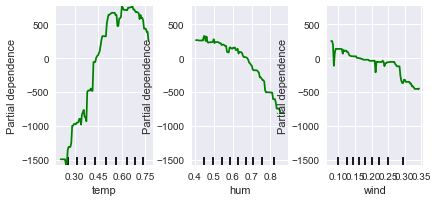

In [22]:
features = [3, 4, 5]
fig, axs = plot_partial_dependence(clf, df_day, features,
                                      feature_names=["", "", "", "temp", "hum", "wind"]
                                       )